In [3]:
import os
import shutil
import random

train_path = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
validation_path = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"
output_train_path = "/kaggle/working/reduced_dataset/train"
output_validation_path = "/kaggle/working/reduced_dataset/valid"

train_samples = 1000
validation_samples = 300

def create_subset(input_path, output_path, samples_per_class):
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    for class_name in os.listdir(input_path):
        class_dir = os.path.join(input_path, class_name)
        if os.path.isdir(class_dir):
            images = os.listdir(class_dir)
            random.shuffle(images)
            selected_images = images[:samples_per_class]
            class_output_dir = os.path.join(output_path, class_name)
            os.makedirs(class_output_dir, exist_ok=True)
            for image in selected_images:
                src = os.path.join(class_dir, image)
                dst = os.path.join(class_output_dir, image)
                shutil.copy(src, dst)
            print(f"Processed class '{class_name}' with {samples_per_class} images.")

create_subset(train_path, output_train_path, train_samples)
create_subset(validation_path, output_validation_path, validation_samples)

print("Subset creation completed.")


Processed class 'Tomato___Late_blight' with 1000 images.
Processed class 'Tomato___healthy' with 1000 images.
Processed class 'Grape___healthy' with 1000 images.
Processed class 'Orange___Haunglongbing_(Citrus_greening)' with 1000 images.
Processed class 'Soybean___healthy' with 1000 images.
Processed class 'Squash___Powdery_mildew' with 1000 images.
Processed class 'Potato___healthy' with 1000 images.
Processed class 'Corn_(maize)___Northern_Leaf_Blight' with 1000 images.
Processed class 'Tomato___Early_blight' with 1000 images.
Processed class 'Tomato___Septoria_leaf_spot' with 1000 images.
Processed class 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot' with 1000 images.
Processed class 'Strawberry___Leaf_scorch' with 1000 images.
Processed class 'Peach___healthy' with 1000 images.
Processed class 'Apple___Apple_scab' with 1000 images.
Processed class 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' with 1000 images.
Processed class 'Tomato___Bacterial_spot' with 1000 images.
Processed 

In [2]:
import os
import numpy as np
import cv2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

train_path = "/kaggle/working/reduced_dataset/train"
validation_path = "/kaggle/working/reduced_dataset/valid"

img_height, img_width = 128, 128
def load_images_from_directory(directory, img_height, img_width):
    data = []
    labels = []
    class_names = os.listdir(directory)
    
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (img_width, img_height))
                img = img.flatten()  
                data.append(img)
                labels.append(label)
    return np.array(data), np.array(labels)


X_train, y_train = load_images_from_directory(train_path, img_height, img_width)
X_val, y_val = load_images_from_directory(validation_path, img_height, img_width)

pca = PCA(n_components=50)  

knn = KNeighborsClassifier(n_neighbors=5)

pipeline = make_pipeline(pca, knn)


pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)
print("Classification Report:")
print(classification_report(y_val, y_pred))

accuracy = np.mean(y_pred == y_val)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.38      0.42       300
           1       0.71      0.92      0.80       300
           2       0.51      0.77      0.61       300
           3       0.40      0.60      0.48       300
           4       0.65      0.70      0.67       300
           5       0.64      0.70      0.67       300
           6       0.65      0.82      0.73       300
           7       0.79      0.79      0.79       300
           8       0.52      0.78      0.62       300
           9       0.62      0.48      0.54       300
          10       0.99      0.97      0.98       300
          11       0.54      0.63      0.58       300
          12       0.53      0.45      0.49       300
          13       0.66      0.28      0.40       300
          14       0.83      0.50      0.62       300
          15       0.67      0.52      0.58       300
          16       0.62      0.78      0.70       300
    

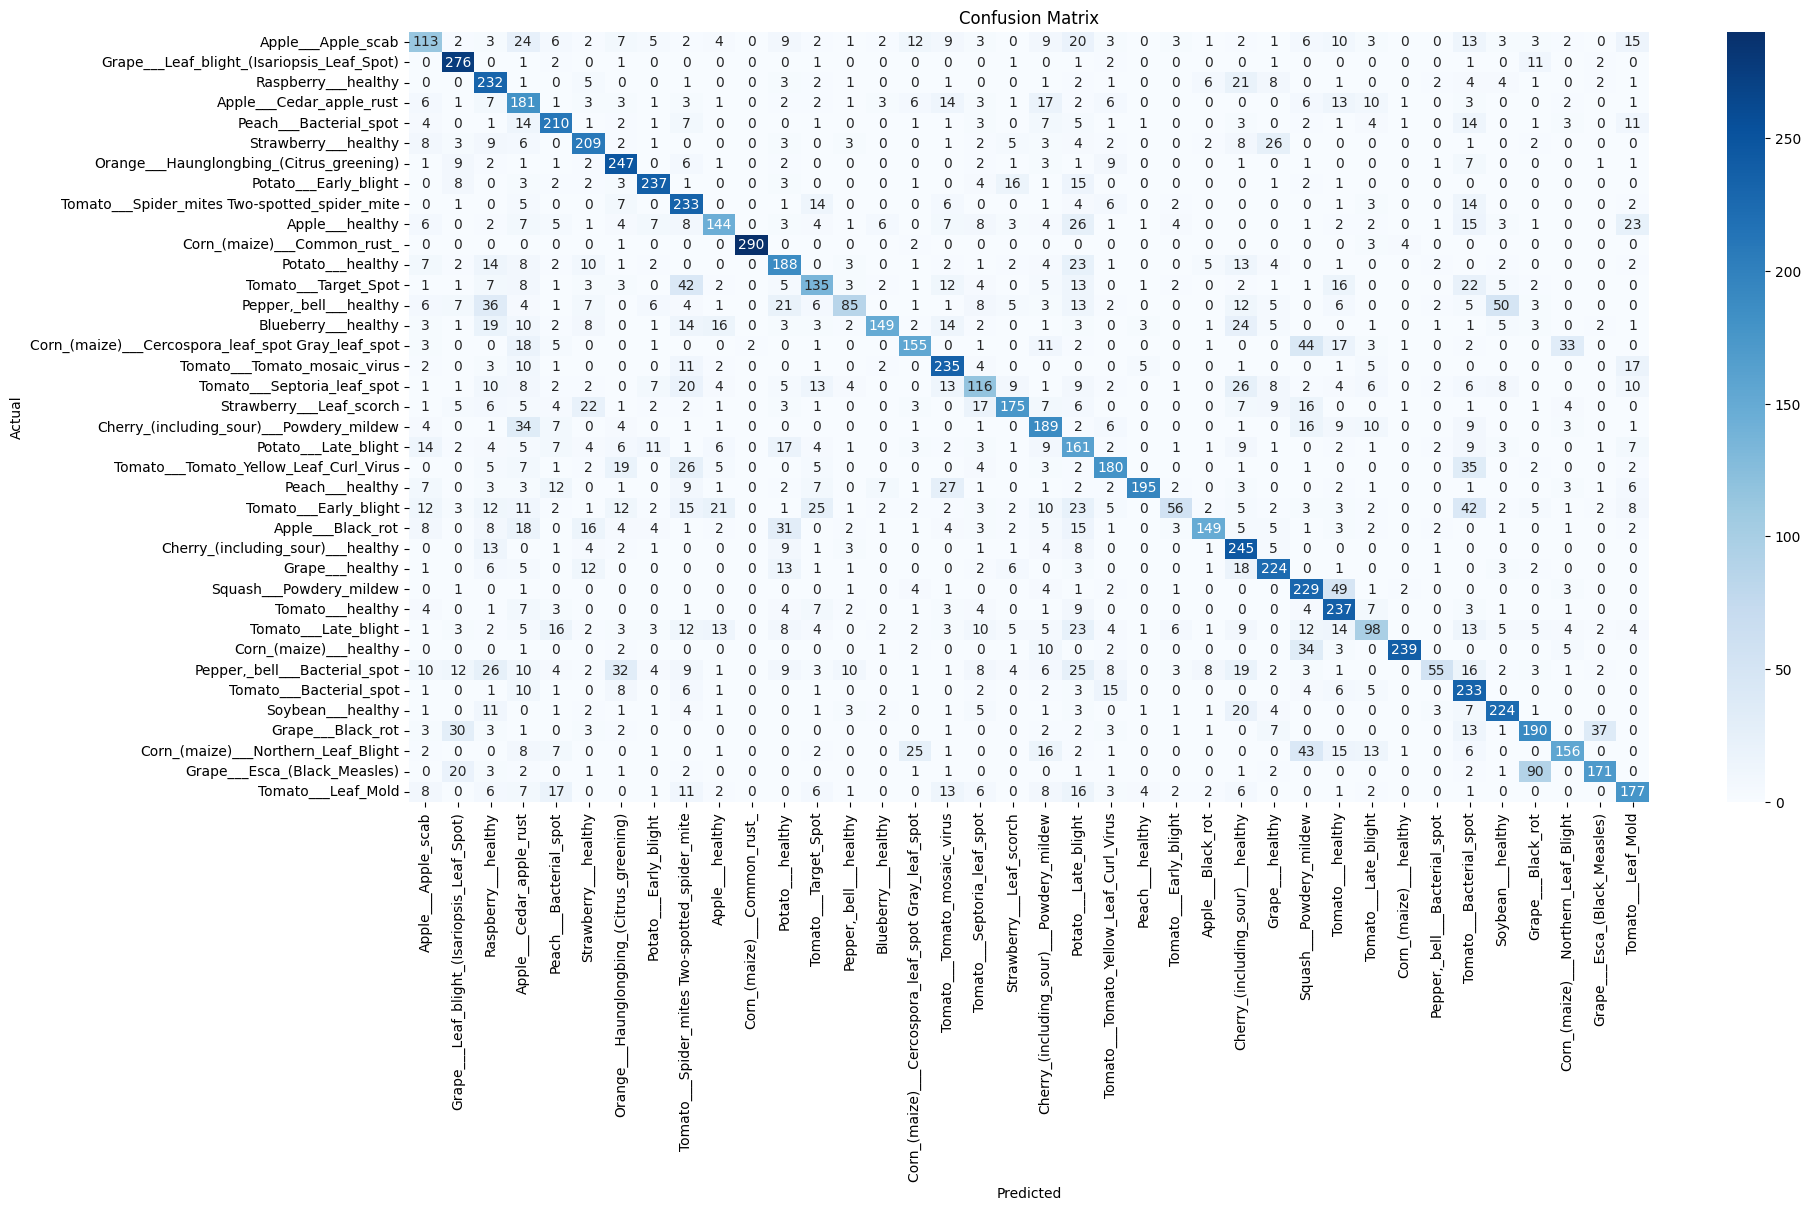

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Get class names from the training directory
class_names = os.listdir(train_path)

# Plot confusion matrix
plt.figure(figsize=(20, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


now we gonna try to extract features in a deffiente way

In [6]:
import cv2
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
import os

# HOG Feature Extraction Function (with grayscale conversion)
def extract_hog_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    hog = cv2.HOGDescriptor()
    features = hog.compute(gray)
    return features.flatten()

# Load images with HOG features
def load_hog_features(directory, img_height, img_width):
    data = []
    labels = []
    class_names = os.listdir(directory)
    
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (img_width, img_height))
                features = extract_hog_features(img)
                data.append(features)
                labels.append(label)
    return np.array(data), np.array(labels)


train_path = "/kaggle/working/reduced_dataset/train"
validation_path = "/kaggle/working/reduced_dataset/valid"

# Load HOG features from training and validation data
X_train, y_train = load_hog_features(train_path, 128, 128)
X_val, y_val = load_hog_features(validation_path, 128, 128)

pca = PCA(n_components=50)  

knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
    'weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(knn, param_grid, cv=3, n_jobs=-1, verbose=2)

pipeline = make_pipeline(pca, grid_search)

# Train the model
print("Training the model with GridSearchCV...")
pipeline.fit(X_train, y_train)

# Get the best parameters from GridSearchCV
best_params = grid_search.best_params_
print("\nBest Hyperparameters found by GridSearchCV:")
print(f"n_neighbors: {best_params['n_neighbors']}")
print(f"metric: {best_params['metric']}")
print(f"weights: {best_params['weights']}")

# Evaluate on validation data
y_pred = pipeline.predict(X_val)

# Classification report and accuracy
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

accuracy = np.mean(y_pred == y_val)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


Training the model with GridSearchCV...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best Hyperparameters found by GridSearchCV:
n_neighbors: 7
metric: euclidean
weights: distance

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.30      0.40       300
           1       0.72      0.88      0.79       300
           2       0.59      0.73      0.65       300
           3       0.68      0.45      0.54       300
           4       0.55      0.58      0.57       300
           5       0.69      0.71      0.70       300
           6       0.85      0.77      0.81       300
           7       0.47      0.65      0.55       300
           8       0.55      0.66      0.60       300
           9       0.42      0.30      0.35       300
          10       0.96      0.88      0.92       300
          11       0.60      0.49      0.54       300
          12       0.42      0.35      0.38       300
          13       0.7

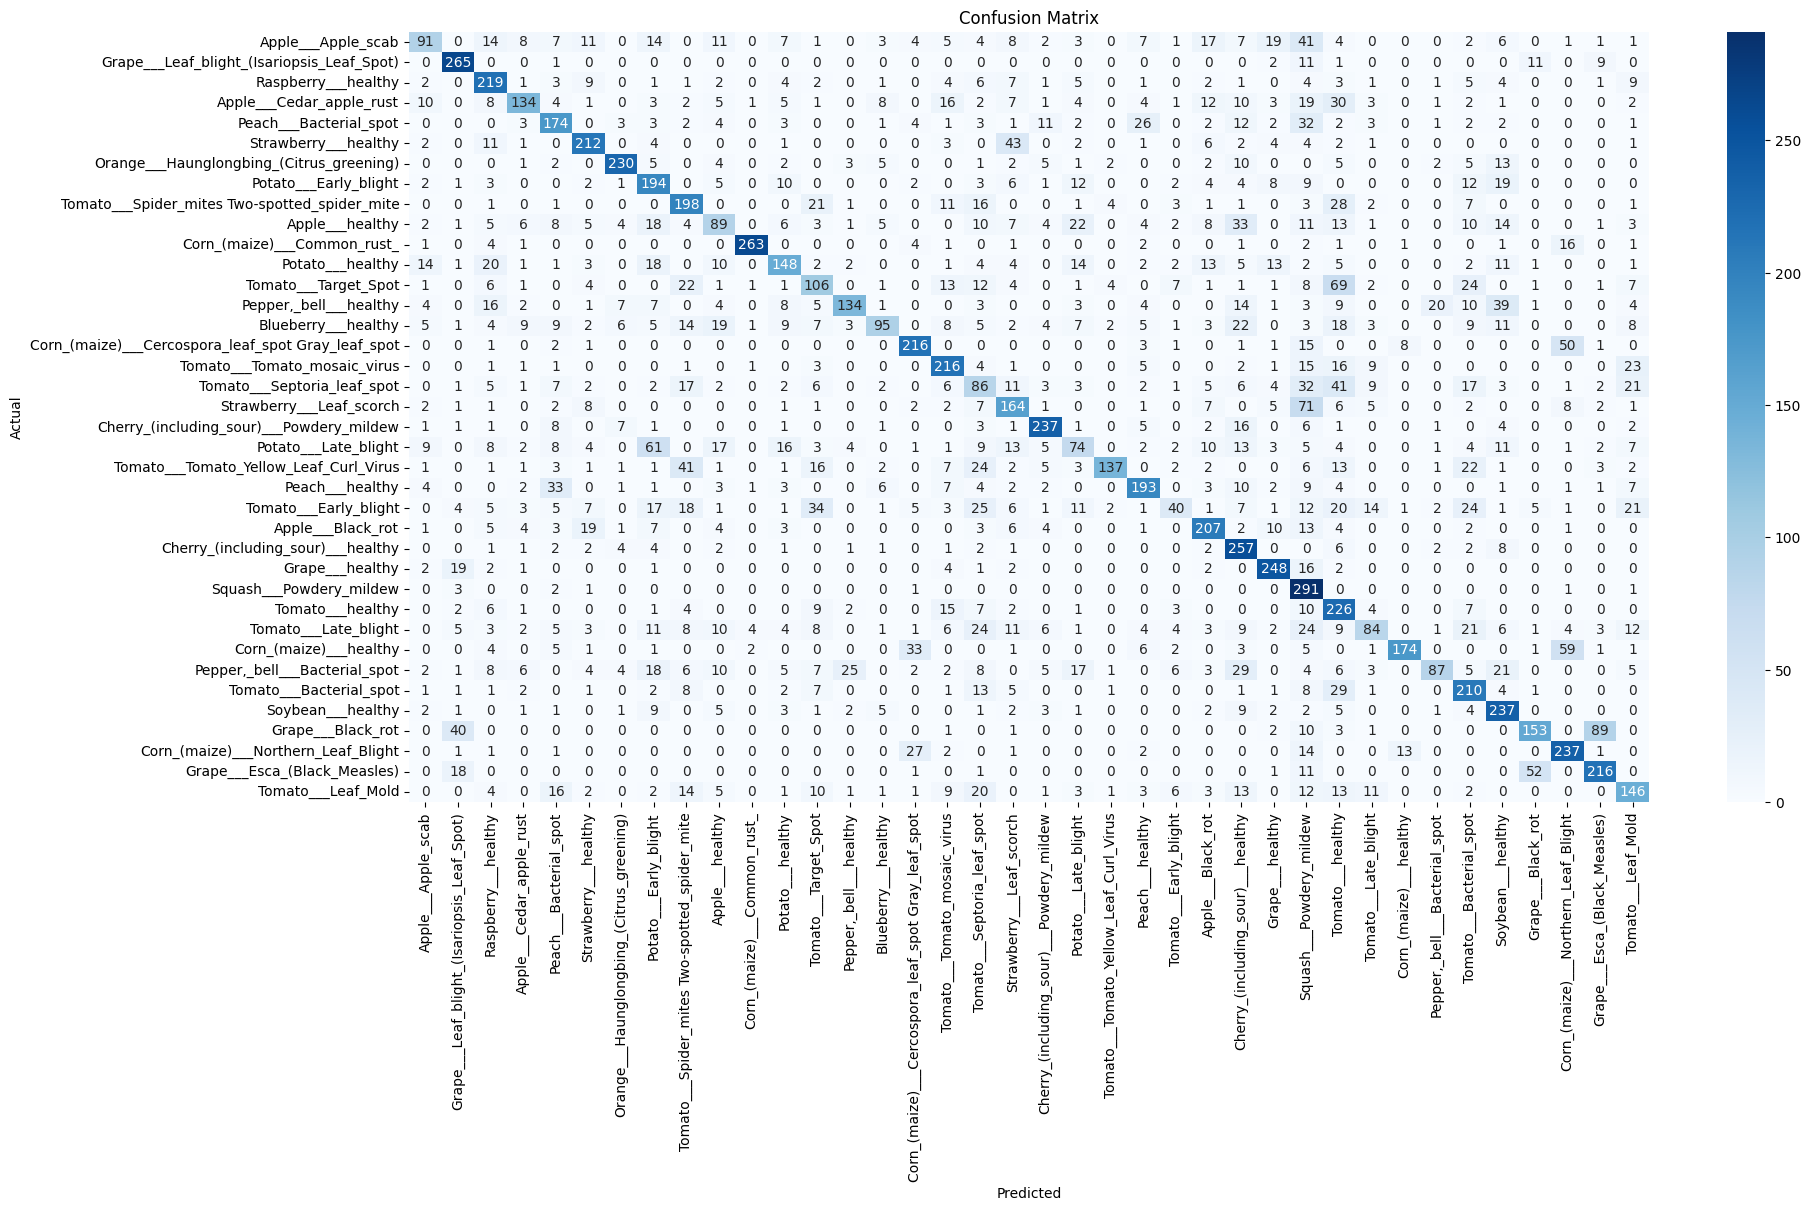

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Get class names from the training directory
class_names = os.listdir(train_path)

# Plot confusion matrix
plt.figure(figsize=(20, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [8]:
import numpy as np
import os
import cv2
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Function to extract color histograms (RGB)
def extract_color_histogram(image, bins=32):

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    hist_r = cv2.calcHist([image_rgb], [0], None, [bins], [0, 256])
    hist_g = cv2.calcHist([image_rgb], [1], None, [bins], [0, 256])
    hist_b = cv2.calcHist([image_rgb], [2], None, [bins], [0, 256])
    

    hist_r = hist_r.flatten() / np.sum(hist_r)
    hist_g = hist_g.flatten() / np.sum(hist_g)
    hist_b = hist_b.flatten() / np.sum(hist_b)

    
    return np.hstack([hist_r, hist_g, hist_b])

# Load and process training and validation data
def load_data(image_dir, img_size=(128, 128)):
    data = []
    labels = []
    label_encoder = LabelEncoder()

    for label in os.listdir(image_dir):
        label_path = os.path.join(image_dir, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                img = cv2.imread(img_path)
                img = cv2.resize(img, img_size)
                hist = extract_color_histogram(img)
                data.append(hist)
                labels.append(label)
    
    # Convert labels to numerical values
    labels = label_encoder.fit_transform(labels)
    return np.array(data), np.array(labels), label_encoder

# Load the training and validation data
train_data_dir = '/kaggle/working/reduced_dataset/train'  # Update with the correct path to your training images
val_data_dir = '/kaggle/working/reduced_dataset/valid'  # Update with the correct path to your validation images

X_train, y_train, label_encoder = load_data(train_data_dir)
X_val, y_val, _ = load_data(val_data_dir)

# Initialize KNN model
knn = KNeighborsClassifier()

# Hyperparameter tuning using GridSearchCV
param_grid = {'n_neighbors': [3, 5, 7, 9, 11],
              'metric': ['euclidean', 'manhattan', 'chebyshev']}
grid_search = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best parameters found: ", grid_search.best_params_)

# Make predictions with the best model
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Best parameters found:  {'metric': 'manhattan', 'n_neighbors': 3}
Validation Accuracy: 78.04%


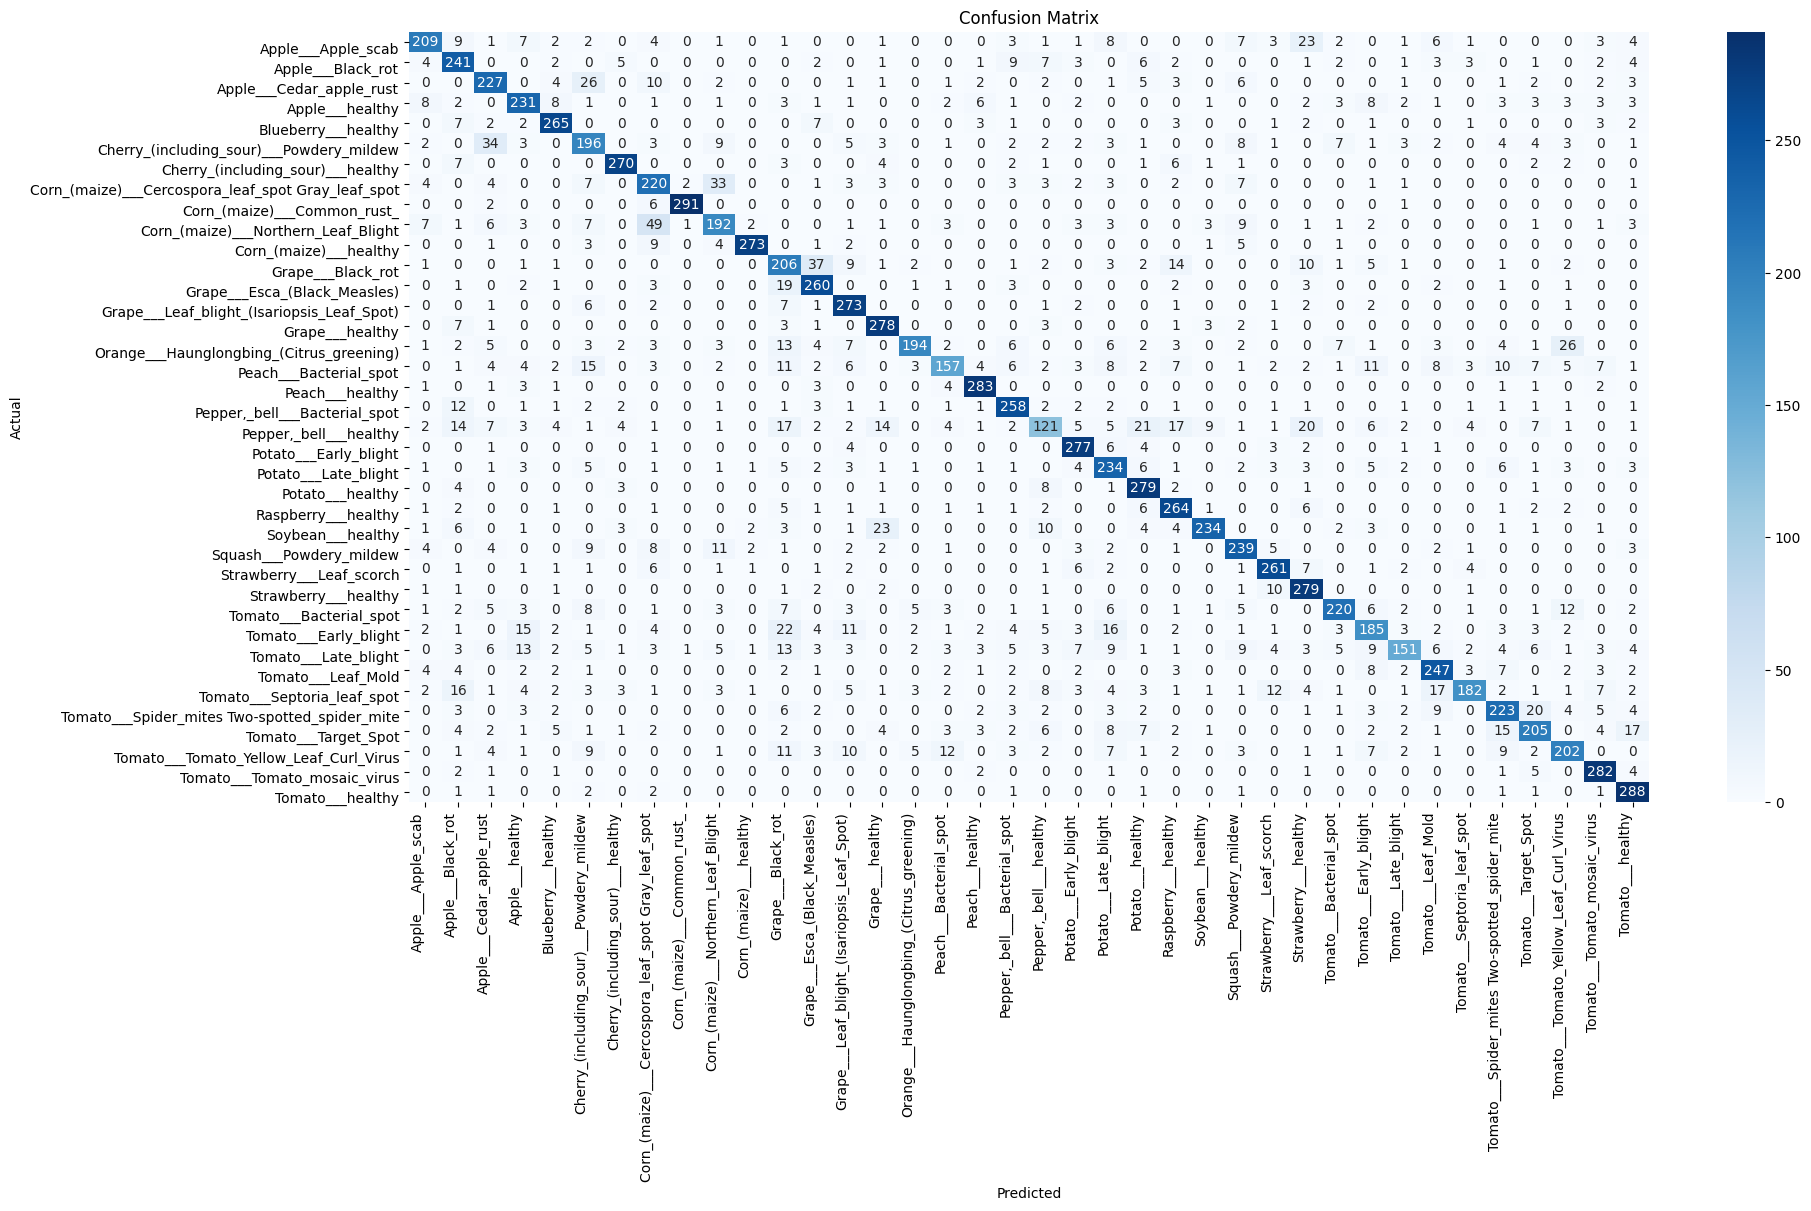

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(20, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Rotate the x-axis and y-axis labels for better readability
plt.xticks(rotation=90, ha='right')  # Rotate x labels
plt.yticks(rotation=0, va='top')    # Rotate y labels

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


In [12]:
import numpy as np
import pywt
import cv2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def wavelet_transform(image, wavelet='haar'):
   
    coeffs2 = pywt.dwt2(image, wavelet)
    cA, (cH, cV, cD) = coeffs2  
    return cA 

def extract_features_wavelet(images, wavelet='haar'):
   
    features = []
    for img in images:
        if len(img.shape) == 3: 
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = cv2.resize(img, (128, 128))
        cA = wavelet_transform(img, wavelet=wavelet)
        features.append(cA.flatten())
    return np.array(features)

train_data_dir = '/kaggle/working/reduced_dataset/train'  
val_data_dir = '/kaggle/working/reduced_dataset/valid'  

X_train, y_train, label_encoder = load_data(train_data_dir)
X_val, y_val, _ = load_data(val_data_dir)

wavelet_type = 'haar' 
print("Extracting wavelet features for training data...")
X_train_wavelet = extract_features_wavelet(X_train, wavelet=wavelet_type)
print("Extracting wavelet features for validation data...")
X_val_wavelet = extract_features_wavelet(X_val, wavelet=wavelet_type)

# Train KNN Model
print("Training KNN model...")
knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan')  # Adjust hyperparameters as needed
knn.fit(X_train_wavelet, y_train)

# Make Predictions
print("Predicting on validation data...")
y_pred = knn.predict(X_val_wavelet)

# Evaluate Model
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))


Extracting wavelet features for training data...
Extracting wavelet features for validation data...
Training KNN model...
Predicting on validation data...
Accuracy: 77.82%

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.68      0.74       300
           1       0.67      0.81      0.73       300
           2       0.70      0.76      0.73       300
           3       0.74      0.76      0.75       300
           4       0.86      0.86      0.86       300
           5       0.62      0.67      0.64       300
           6       0.90      0.90      0.90       300
           7       0.64      0.77      0.70       300
           8       0.99      0.97      0.98       300
           9       0.70      0.62      0.66       300
          10       0.97      0.93      0.95       300
          11       0.57      0.68      0.62       300
          12       0.76      0.84      0.80       300
          13       0.79      0.91      0.85    

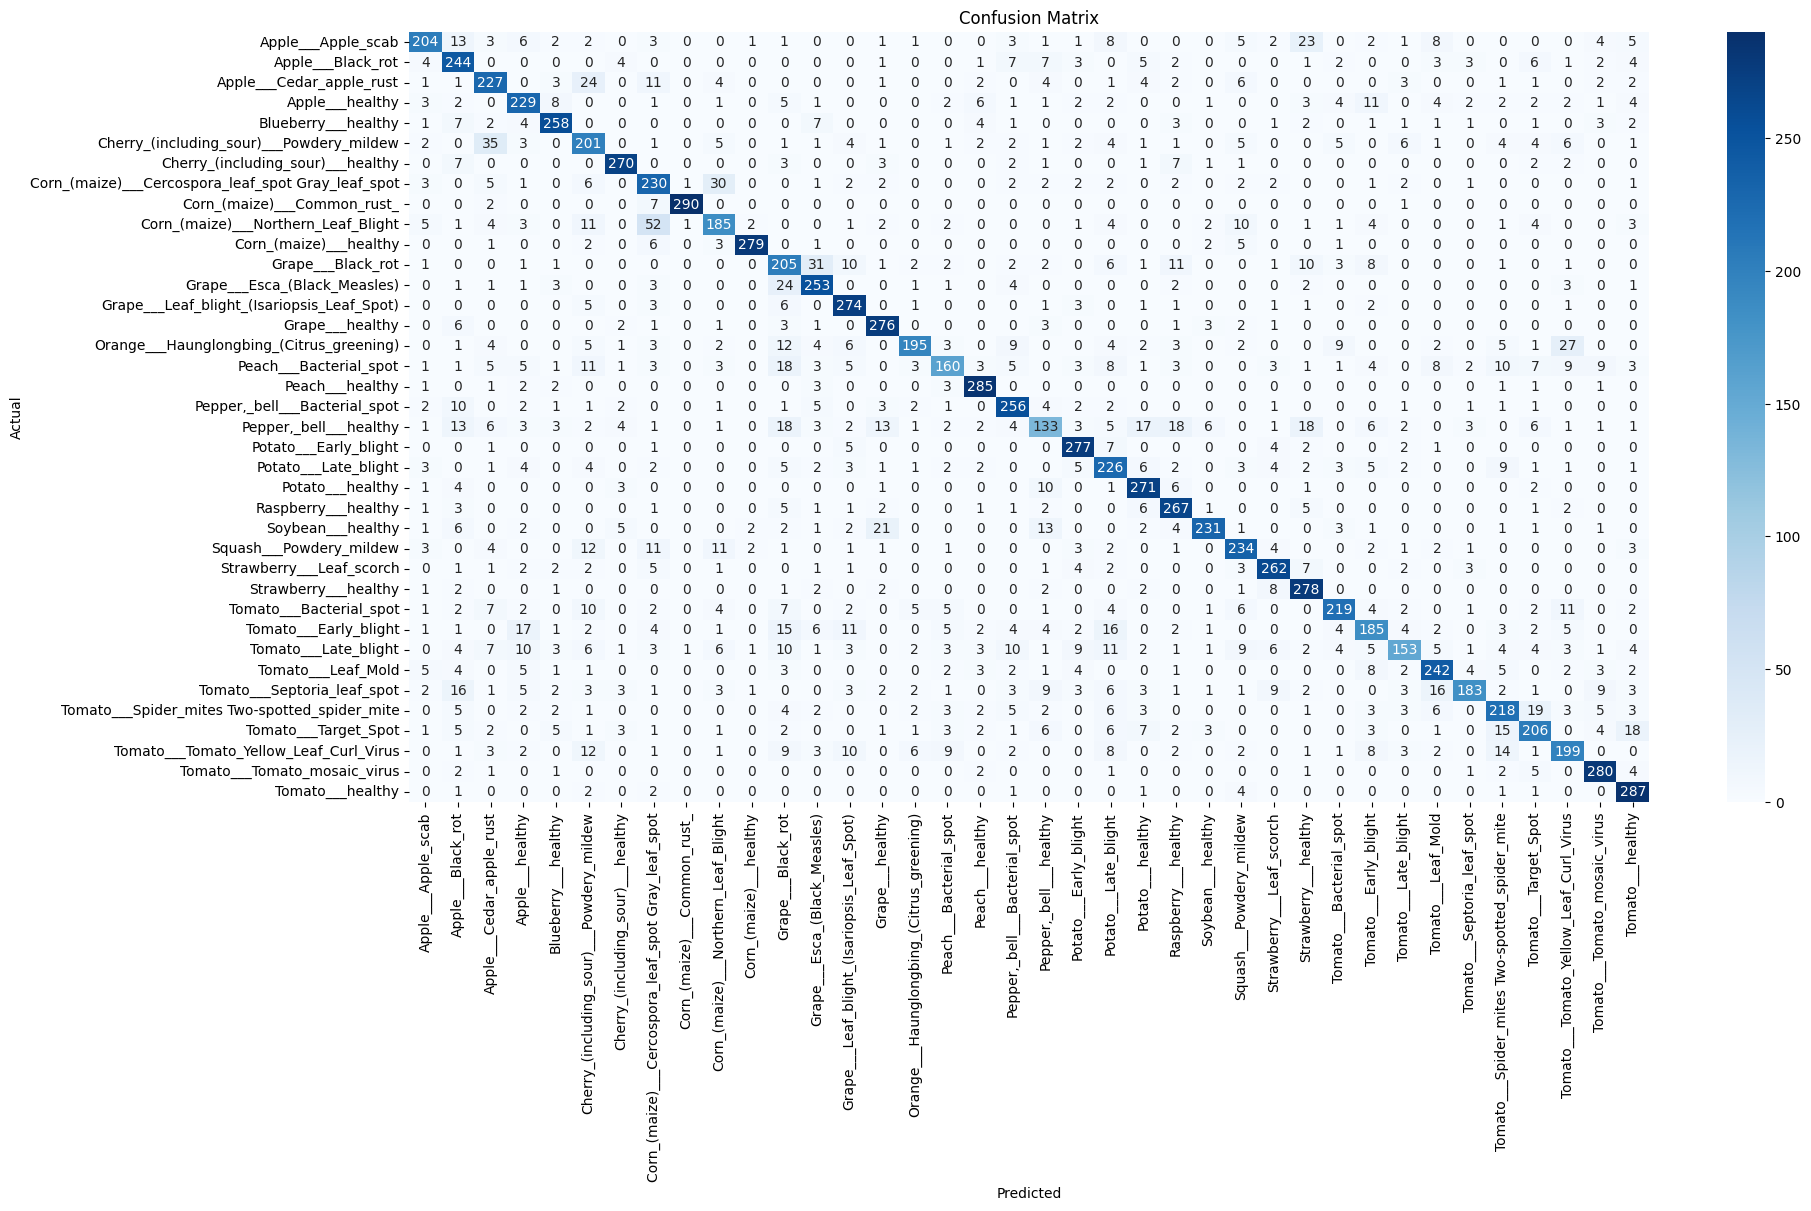

In [13]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(20, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


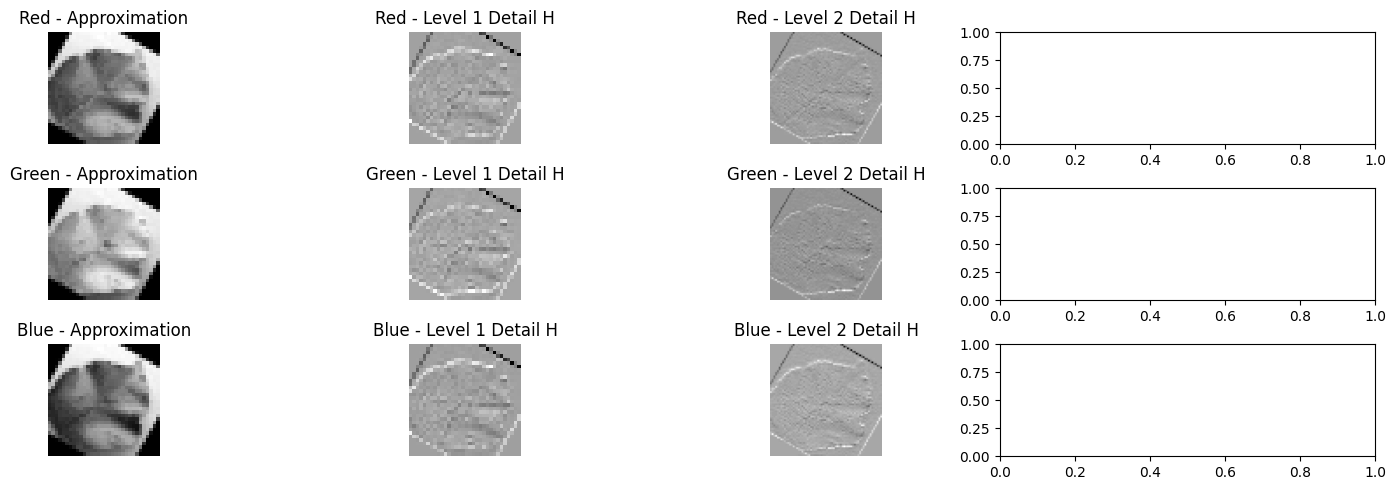

In [22]:
import cv2
import pywt
import matplotlib.pyplot as plt

def wavelet_decompose_image(image, wavelet='haar', level=2):
    """
    Decompose a color image using a 2D wavelet transform on each channel.
    """
    # Split the image into its color channels (R, G, B)
    channels = cv2.split(image)
    decomposed_channels = []

    for channel in channels:
        # Perform wavelet decomposition on each channel
        coeffs = pywt.wavedec2(channel, wavelet=wavelet, level=level)
        decomposed_channels.append(coeffs)
    
    return decomposed_channels

def plot_wavelet_decomposition(decomposed_channels, level=2):
    """
    Plot the wavelet decomposition for each channel.
    """
    fig, axes = plt.subplots(len(decomposed_channels), 2 + level, figsize=(15, 5))
    colors = ['Red', 'Green', 'Blue']

    for i, coeffs in enumerate(decomposed_channels):
        cA = coeffs[0]  # Approximation coefficients
        axes[i, 0].imshow(cA, cmap='gray')
        axes[i, 0].set_title(f"{colors[i]} - Approximation")
        axes[i, 0].axis("off")

        for j in range(1, level + 1):
            cH, cV, cD = coeffs[j]
            axes[i, j].imshow(cH, cmap='gray')
            axes[i, j].set_title(f"{colors[i]} - Level {j} Detail H")
            axes[i, j].axis("off")
    
    plt.tight_layout()
    plt.show()

# Load the original image
image_path = "/kaggle/working/reduced_dataset/valid/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335_new30degFlipLR.JPG"  # Replace with your image path
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting

# Resize for consistency
resized_image = cv2.resize(original_image, (128, 128))

# Decompose the image using 2D wavelet transform
decomposed_channels = wavelet_decompose_image(resized_image, wavelet='haar', level=2)

# Visualize the wavelet decomposition
plot_wavelet_decomposition(decomposed_channels, level=2)


In [ ]:
clf=tree.DecisionTreeRegressor()
        clf.fit(x,y)
        x_test=[]
        y_test=[]
        i=0
        for class_name, feature_list in prepared_validation_data.items():
            for features in feature_list:
                x_test.append(features)  
                y_test.append(i)
            i=i+1
        y_pred=clf.predict(x_test)
        print(classification_report(y_test,y_pred))
        print(accuracy_score(y_test,y_pred))